In [42]:
# Getting List of Species from Assemblies 

from Bio import Entrez
import pandas as pd
import re
from mymail import mail

Entrez.mail = mail
handle = Entrez.esearch(db="assembly", retmax=10000, term="\"(Archaea\"[Organism] OR \"Eukaryota\"[Organism]) AND (latest[filter] AND (\"chromosome level\"[filter] OR \"complete genome\"[filter]) AND all[filter] NOT anomalous[filter])", )
# handle = Entrez.esearch(db='assembly', retmax=1, term="GRCh38.p14")
record = Entrez.read(handle)
handle.close()

AssemblyTable = {'AssemblyName': [], 'Organism': []}
for ID in record['IdList']:
    handle = Entrez.efetch(db="assembly", id=ID, rettype='docsum', retmode='xml')
    try:
        AssemblyRecord = Entrez.read(handle, validate = False)['DocumentSummarySet']['DocumentSummary'][0]
    except:
        continue
    # print(Entrez.read(handle)['DocumentSummarySet']['DocumentSummary'][0])
    AssemblyName = AssemblyRecord['AssemblyName']
    AssemblyOrganism = AssemblyRecord["Organism"]
    AssemblyTable['AssemblyName'].append(AssemblyName)
    AssemblyTable['Organism'].append(re.sub(r" \(.*\)", "", AssemblyOrganism))
AssemblyTable = pd.DataFrame(AssemblyTable)
AssemblyTable.to_csv('./InputData/AssemblyTable.csv', index=False)


In [ ]:
#TODO: mb delete this at the end
from Bio import Entrez
import pandas as pd
import re
from mymail import mail

Entrez.email = mail
handle = Entrez.esearch(db='gene', retmax=1, term='"Eukaryota"[Organism] AND rps11[Gene Name] AND ("source_genomic"[properties] AND alive[prop])')
record = Entrez.read(handle)
handle.close()

for ID in record['IdList']:
    handle = Entrez.efetch(db='gene', id=ID, retmode='xml')
    print(Entrez.read(handle)[0])

In [7]:
# Formatting S11input.tsv and AK6input.tsv
import pandas as pd
import re

def format_input_data(FileName):
    DF = pd.read_csv(f'{FileName}', sep = '\t' ,index_col=False)

    for Organism in DF['Organism']:
        DF.loc[DF['Organism'] == Organism, 'Organism'] = re.sub('\(.*\)', '', Organism)

    # DF.loc[DF['Organism'].str.contains("Homo")].head()
    DF
    DF.to_csv(f'{FileName}', sep='\t', index=False)

format_input_data('./InputData/S11Input.tsv')
format_input_data('./InputData/AK6Input.tsv')

In [119]:
# Formatting AK6Input.csv
import pandas as pd
import re

DF = pd.read_csv('./InputData/AK6Input.csv', index_col=False)

for Organism in DF['Organism']:
    DF.loc[DF['Organism'].str.contains(Organism), 'Organism'] = re.sub('\(.*\)', '', Organism)

DF
DF.to_csv('./InputData/AK6Input.csv', index=False)

In [2]:
# Finding needed rows
import pandas as pd

AssemblyFrame = pd.read_csv('./InputData/AssemblyTable.csv', index_col=False)
AK6Frame = pd.read_csv('./InputData/AK6Input.tsv', sep='\t', index_col=False)
S11Frame = pd.read_csv('./InputData/S11Input.tsv', sep='\t', index_col=False)
OrganismList = set(AssemblyFrame['Organism'].to_list())

def filter_rows(DF, FileName):
    
    NewDF = pd.DataFrame()
    for Organism in OrganismList:
        ToAdd = DF.loc[DF['Organism'].str.contains(Organism)]
        NewDF = pd.concat([NewDF, ToAdd])
    
    NewDF = NewDF.sort_values(['Reviewed','Annotation'], ascending = [True,False])
    NewDF = NewDF.drop_duplicates('Organism', keep = 'first')
    NewDF.to_csv(f'{FileName}.csv', index=False)

filter_rows(AK6Frame, './InputData/FilteredAK6')
filter_rows(S11Frame, './InputData/FilteredS11')
# NewAK6Frame.loc[NewAK6Frame['Organism'].str.contains('Homo sapiens')]

In [3]:
# Working with uS11 C-ter
# TODO: Add new column for second protein and save all this in another file 
import pandas as pd
import re

S11Frame = pd.read_csv('./InputData/FilteredS11.csv' , index_col=False)
CTerGroup = []
for Sequence in S11Frame['Sequence']:
    Sequence = Sequence[-40:]
    if re.findall('D.{6}D', Sequence) != [] :
        CTerGroup.append(1)
    else:
        CTerGroup.append(0)

S11Frame['C-ter_group'] = pd.Series(CTerGroup)

S11Frame.to_csv('./InputData/FilteredS11.csv', index=False)

In [34]:
# Finding Interaction between AK6 and S11
import pandas as pd

S11Frame = pd.read_csv('./InputData/FilteredS11.csv' , index_col=False)
AK6Frame = pd.read_csv('./InputData/FilteredAK6.csv' , index_col=False)
S11Frame.rename(columns={'Sequence':'S11_Sequence'}, inplace=True)

FinalFrame = pd.DataFrame(columns=['Organism', 'S11_Sequence', 'C-ter_group', 'AK6_group'])
FinalFrame = pd.concat([FinalFrame, S11Frame[['Organism', 'S11_Sequence', 'C-ter_group']]], join='outer')
AK6Group = []
for Organism in FinalFrame['Organism']:
    if Organism in AK6Frame['Organism'].to_list():
        AK6Group.append(1)
    else:
        AK6Group.append(0)

FinalFrame['AK6_group'] = AK6Group
FinalFrame
FinalFrame.to_csv('./OutputData/FinalData.csv', index=False)

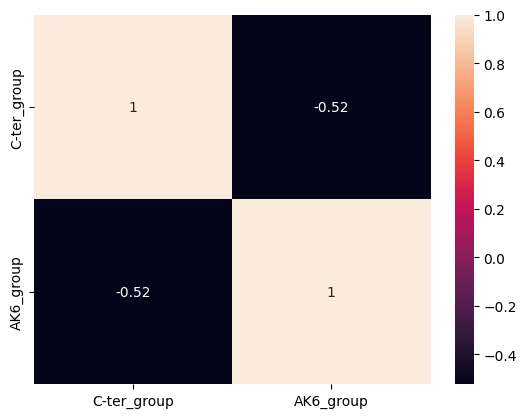

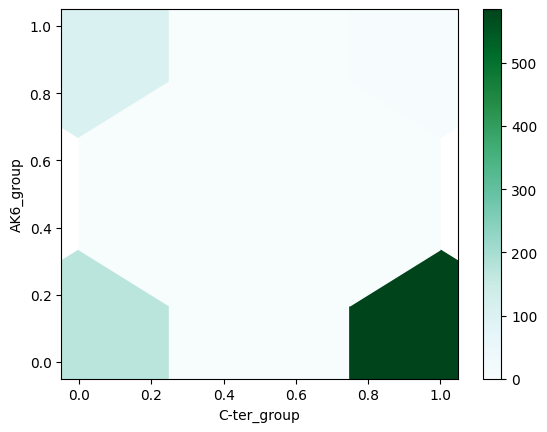

In [47]:
# Statistical analysis and visualization

import pandas as pd
import seaborn as sns

FinalFrame = pd.read_csv('./OutputData/FinalData.csv', index_col=False)

sns.heatmap(FinalFrame.corr().round(3), annot=True).get_figure().savefig('./OutputData/Correlation')
FinalFrame.plot.hexbin(x='C-ter_group',y='AK6_group', gridsize=2).get_figure().savefig('./OutputData/HexPlot')